# WRF Precip and ET for specific year
- compare to billy barr precipitation and snotel precipitation to WRF grid cell output within the ER
- get a map of these sites and compare the grid cell values to monthly climatology
- Look at bar chart of 2016 SWE from ASO + non-snow precip - ET(WRF) - GW_level SM

In [1]:
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nctoolkit as nctk

from soslib import funcs
from metpy.units import units
import metpy.calc as calc
from dataretrieval import nwis 
from metloom.pointdata import SnotelPointData

import datetime as dt

import rioxarray as rioxr
import geopandas as gpd
import fiona 
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot, mask

nctoolkit is using Climate Data Operators version 2.1.0


# Year of interest: 2018

In [19]:
study_year = 2018
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('./multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

### Pull in billy barr data and clean it up a bit

In [20]:
# Coordinated for Gothic, CO
gothic_coords  = [38.959158, -106.9897676]

# Climatorology including precipitation, snowfall and temperature for each month
bb_climatology = pd.read_csv('../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]
bb_climatology['water_cm'] = bb_climatology['water_cm'].astype(float)
dates = pd.to_datetime([f"{bb_climatology.loc[i,'WY']}-{bb_climatology.loc[i,'Month']}-01" for i in bb_climatology.index], format='%Y-%m-%d')
date_list=[]

for i,date in enumerate(dates):
    if date.year == 1900:
        date = dt.date(2000,date.month,date.day)
    if date.month in [9,10,11,12]:
        date = dt.date(date.year-1,date.month,date.day)
    else:
        date = dt.date(date.year,date.month,date.day)
    date_list.append(date)
bb_climatology.index=date_list
bb_climatology = bb_climatology.drop(['Month', 'Year'], axis=1)
for col in bb_climatology:
    bb_climatology[col] = bb_climatology[col].astype(float)


# Monthly snowfall going back to WY 1974
bb_snowfall = pd.read_csv('../data/billy_barr_snowfall.csv', sep='\s+')
bb_snowfall = bb_snowfall.set_index('WY')

# Monthly accumulated precipitation going back to 1974 (for winter) and 1990 for all years
bb_monthly_precip = pd.read_csv('../data/billy_barr_total_monthly_P.csv', sep='\s+')
bb_monthly_precip = bb_monthly_precip.replace(-9999.,np.nan)
bb_monthly_precip = bb_monthly_precip.set_index('WY')


### Load up Snotel data for Butte, Schofield Pass and Park Cone

In [21]:
er_sntl_data = xr.open_dataset('../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

#### Get Snotel point geometry locations

In [22]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("680:CO:SNTL", "Park Cone")
park_cone_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_pass_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("1141:CO:SNTL", "Upper Taylor")
schofield_pass_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]


### Grab the water equivalent data and produce the snow on and snow off dates for us against the WRF output.
- using Butte here as a proxy... due to it being at around the mean elevation of the watershed. (Need to confirm this with a DEM)

In [36]:
snow_wteq_daily = er_sntl_data.sel(Location='Butte_380:CO:SNTL').where(er_sntl_data.WY==study_year)['WTEQ']

snow_on_date = snow_wteq_daily.where(snow_wteq_daily>0).dropna(dim='Date').to_dataframe().index[0]
snow_off_date = snow_wteq_daily.sel(Date=slice(f'{study_year}-01-01',f'{study_year}-09-30')).where((snow_wteq_daily==0)).idxmin().values

In [37]:
monthly_sntl_precip = er_sntl_data['PREC'].resample(Date='1M').sum().sel(Date=slice('2017-10-01','2018-09-30'))

### Load WRF output from Rudissill 2022 for the study year

In [38]:
wy2018_wrf_ds = xr.open_mfdataset(f'../../../../../storage/dlhogan/sos/data/WY{study_year}/*.nc')


In [39]:
wy2018_wrf_monthly_p_ds = wy2018_wrf_ds['ACCPRCP'].resample(XTIME='1M').mean()

In [40]:
# Set constant values for latent heat of sublimation and latent heat of evaporation
Lv = 2.501e6 # J kg-1
Ls = 2.834e6 # J kg-1

In [41]:
# Creates a mask to mask out aboe and below freezing conditions
below_freezing_mask = ((wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True)['T2'] <= 273.15) &
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME >= snow_on_date) & 
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME < snow_off_date) ) 

above_freezing_mask = ((wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True)['T2'] > 273.15) &
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME < snow_on_date) | 
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME >= snow_off_date) ) 

Apply mask to compute the hourly, monthly, and annual ET rate

In [42]:
sublimation = wy2018_wrf_ds.where(below_freezing_mask).LH/Ls * 3600
evaporation = wy2018_wrf_ds.where(above_freezing_mask).LH/Lv * 3600

et_hourly = xr.merge([sublimation,evaporation])
et_hourly = et_hourly.rename_vars({'LH':'ET_rate'})
et_hourly['ET_rate'] = et_hourly.ET_rate
et_hourly['ET_rate'] = et_hourly.ET_rate.assign_attrs({"units":"mm/hr"})

et_monthly = ((et_hourly*24*30).resample(XTIME='1M')).mean()
et_monthly['ET_rate'] = et_monthly.ET_rate.assign_attrs({"units":"mm/month"})

et_yearly = et_monthly.sum(dim='XTIME')
et_yearly['ET_rate'] = et_yearly.ET_rate.assign_attrs({"units":"mm/year"})

In [43]:


# Setup a function to deal with flexible indexing
def kdtree_sel(ds, lats, lons):
    """
    Uses xoak to select data with irregular dimensions

    Parameters
    ----------
    ds : `xarray.Dataset`
      Dataset with your data, with lat/lon dims in one-dimension

    lats : list
      List of latitudes to select

    lons : list
      List of longitudes to select

    Returns
    -------
    ds : `xr.Dataset`
      Dataset subset based on input lats/lons
    """

    # Checks to see if this has an xoak index - if not, create one using the extension
    if not ds.xoak.index:
        ds.xoak.set_index(["XLAT", "XLONG"], "scipy_kdtree")

    # Return the selected datasets
    return ds.xoak.sel(XLAT=xr.Variable("ncol", lats), XLONG=xr.Variable("ncol", lons))

In [45]:
gothic_wrf_monthly = kdtree_sel(wy2018_wrf_monthly_p_ds, [gothic_coords[0]], [gothic_coords[1]])
butte_wrf_monthly = kdtree_sel(wy2018_wrf_monthly_p_ds, [butte_loc.y], [butte_loc.x])

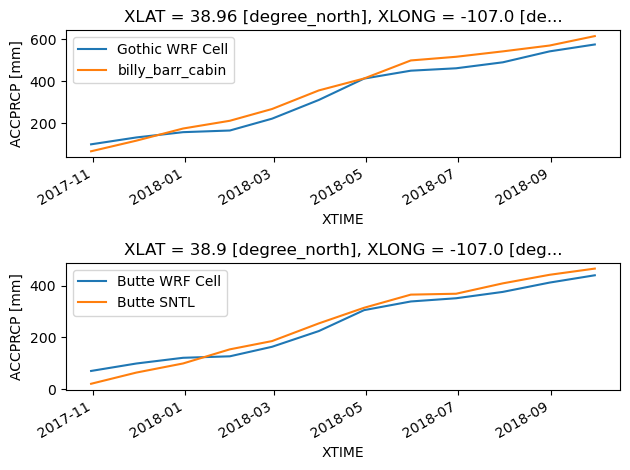

In [46]:
fig, axs = plt.subplots(2, tight_layout=True)

gothic_wrf_monthly.plot(label='Gothic WRF Cell', ax = axs[0])
axs[0].plot(gothic_wrf_monthly.XTIME,(bb_monthly_precip.loc[2018].cumsum()*25.4), label='billy_barr_cabin')
axs[0].legend()

(butte_wrf_monthly).plot(label='Butte WRF Cell', ax=axs[1])
axs[1].plot(butte_wrf_monthly.XTIME,(monthly_sntl_precip.sel(Location='Butte_380:CO:SNTL'))/2.54, label='Butte SNTL')
axs[1].legend()

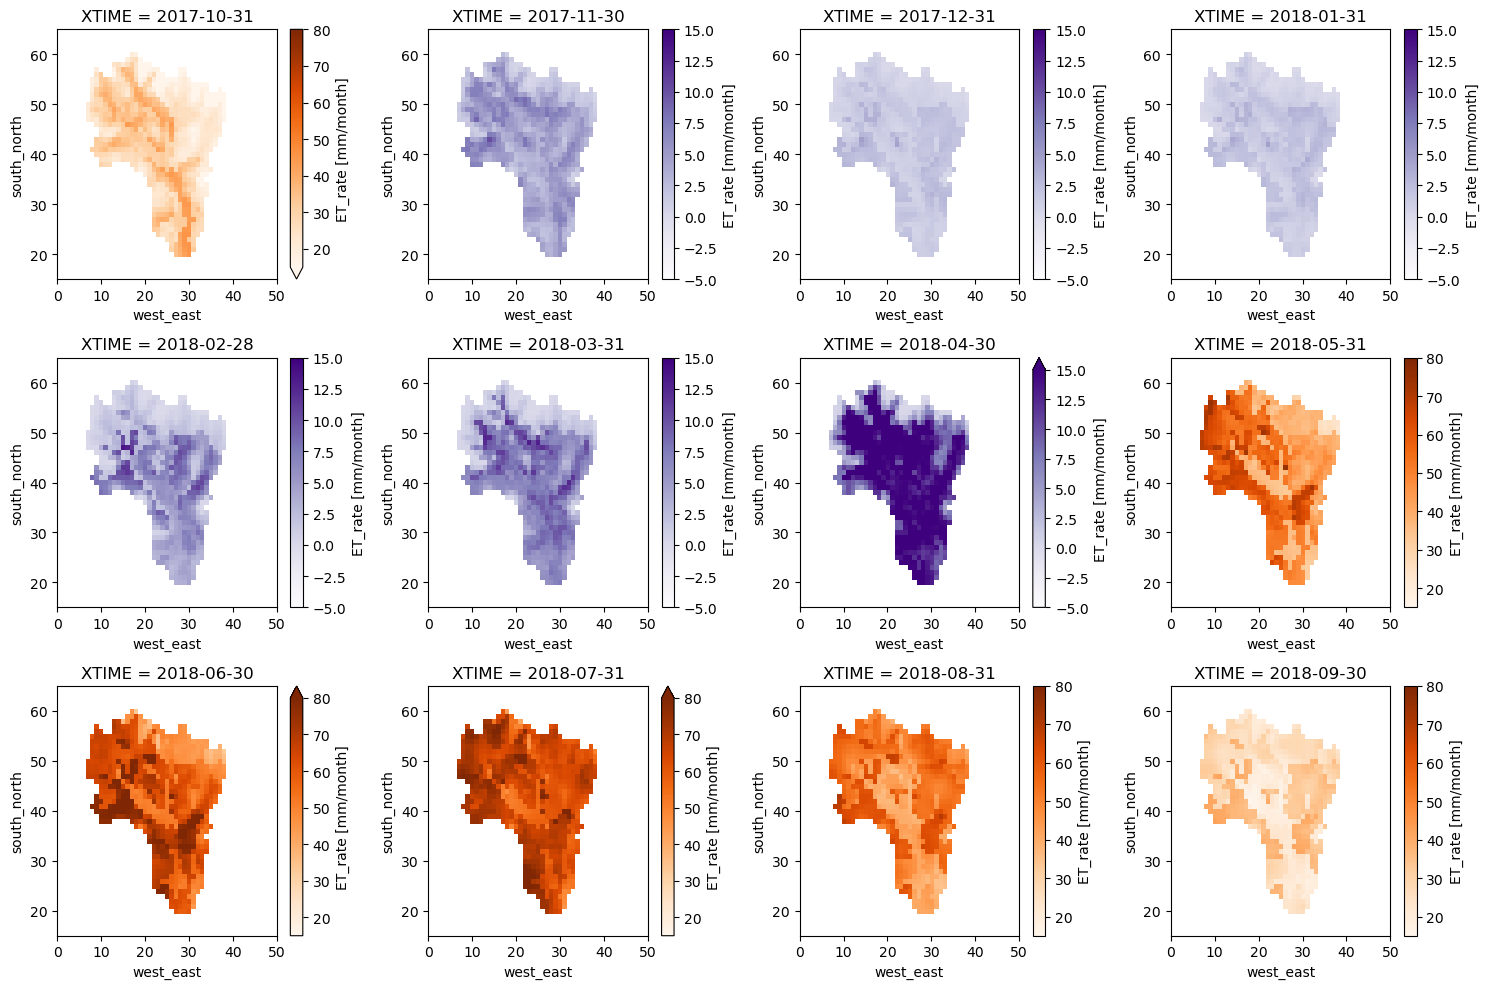

In [47]:
fig, axs = plt.subplots(3,4, figsize=(15,10), tight_layout=True)
axs = axs.ravel()
for i,ax in enumerate(axs):
    if i in [1,2,3,4,5,6]:
        et_monthly.ET_rate.where(wy2018_wrf_ds.EAST_MASK==True).isel(XTIME=i).compute().plot.imshow(ax=ax, cmap='Purples', vmin=-5, vmax=15)
    else:
        et_monthly.ET_rate.where(wy2018_wrf_ds.EAST_MASK==True).isel(XTIME=i).compute().plot.imshow(ax=ax, cmap='Oranges', vmin=15, vmax=80)
    ax.set_xlim(0,50)
    ax.set_ylim(15,65)

(15.0, 65.0)

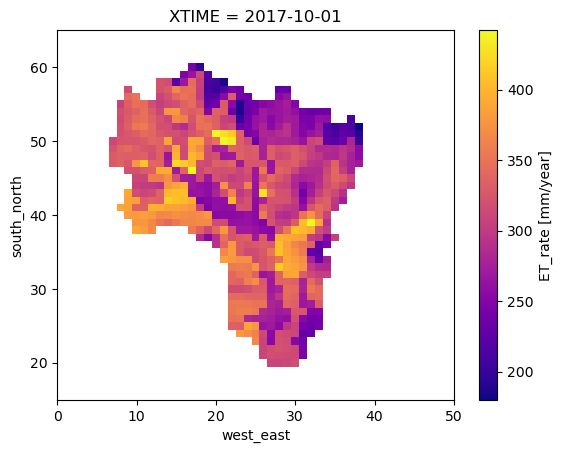

In [53]:
et_yearly.ET_rate.where(wy2018_wrf_ds.EAST_MASK==True).isel(XTIME=0).compute().plot.imshow(cmap='plasma')
plt.xlim(0,50)
plt.ylim(15,65)

### Create groups for each season for ET (DJF-MAM-JJA-SON) and Precip

# Look at DEM for East River

In [23]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
east_river_polygon = upper_east_river_poly.to_crs("32613")

src_swe = rasterio.open('../../../../../storage/dlhogan/sos/data/ASO/ASO_3M_PCDTM.001/2018.09.08/ASO_3M_PCDTM_USCOGE_20180908_20180913.tif')
src_ma, src_ma_transform = rasterio.mask.mask(src_swe, upper_east_river_poly.geometry,**rio_mask_kwargs)
east_ma_extent = rasterio.plot.plotting_extent(src_ma, src_ma_transform)

Text(0.5, 1.0, 'Mean Elev = 3252.86 m')

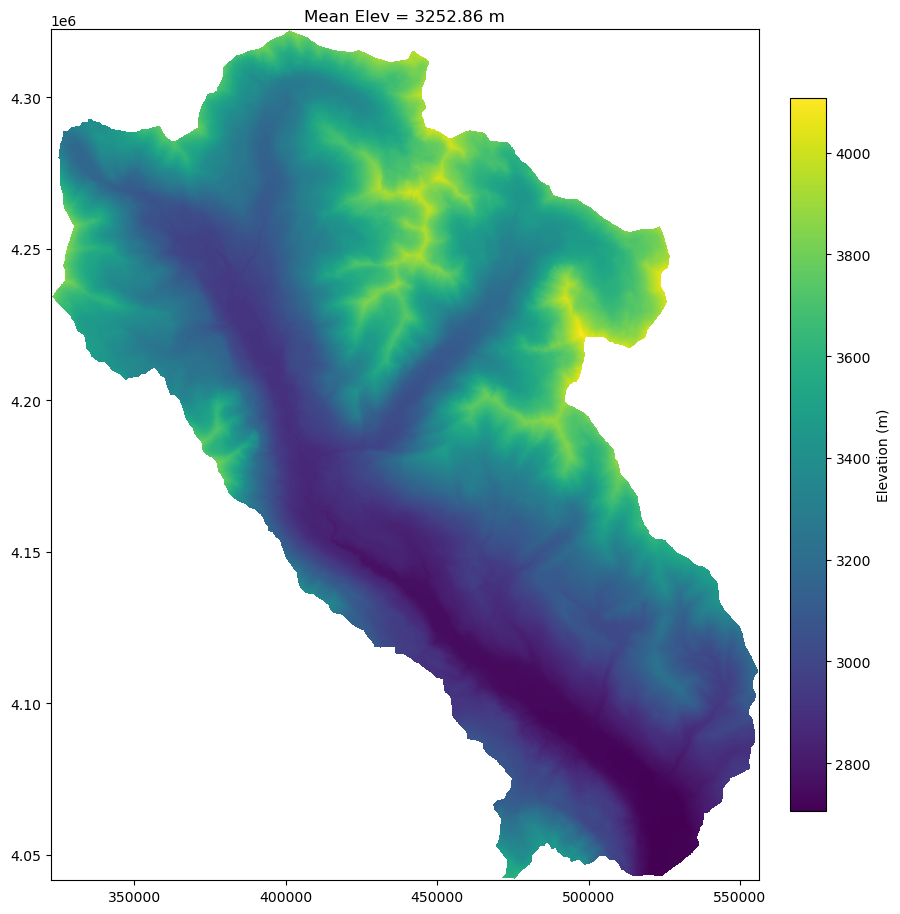

In [35]:
fig, ax = plt.subplots(figsize=(10,20))

# east_river_polygon.boundary.plot(ax=ax,label='East River Watershed', color='r', ls='--')
cax = ax.imshow(src_ma, extent=east_ma_extent, cmap='viridis')
# ax.set_title('April 21, 2022 SWE')
plt.colorbar(cax, label = 'Elevation (m)', ax=ax, fraction=0.046, pad=0.04)
plt.title(f'Mean Elev = {3252.86} m')

# ASO Data for Study Year

In [30]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
east_river_polygon = upper_east_river_poly.to_crs("32613")

src_swe = rasterio.open('../../../../../storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOGE_20180331.tif')
src_ma_swe, src_ma_transform = rasterio.mask.mask(src_swe, upper_east_river_poly.geometry,**rio_mask_kwargs)
east_ma_extent = rasterio.plot.plotting_extent(src_ma, src_ma_transform)

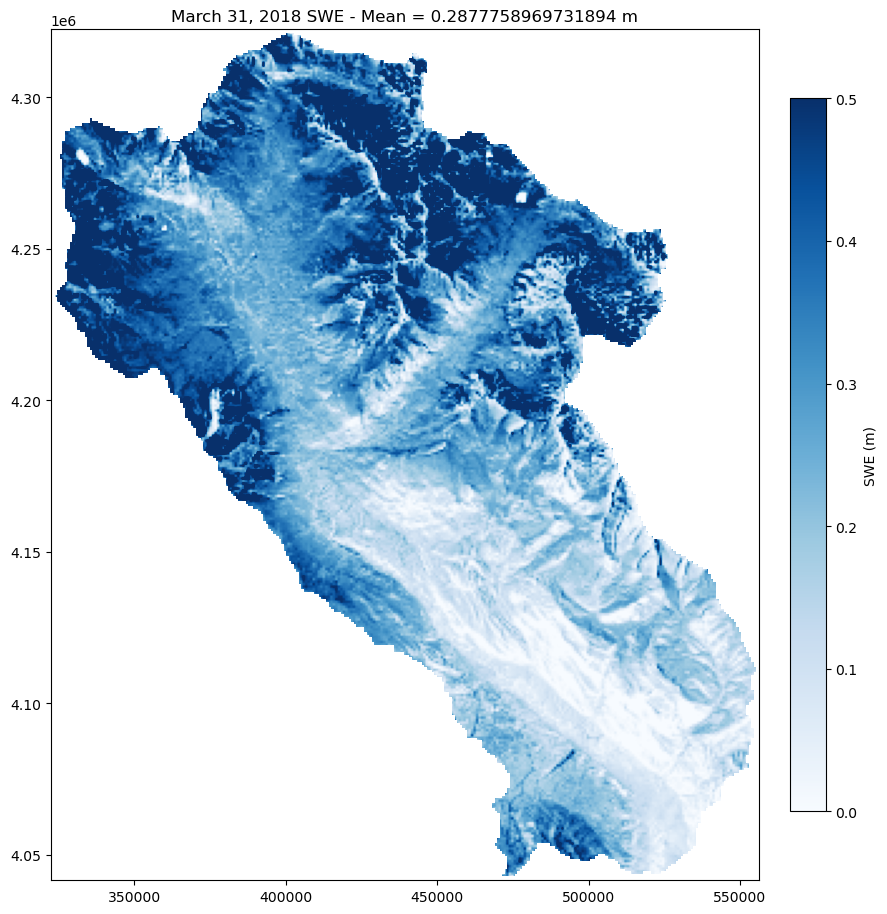

In [33]:
fig, ax = plt.subplots(figsize=(10,20))

# east_river_polygon.boundary.plot(ax=ax,label='East River Watershed', color='r', ls='--')
cax = ax.imshow(src_ma_swe, extent=east_ma_extent, cmap='Blues', vmin=0, vmax=0.5)
ax.set_title(f'March 31, 2018 SWE - Mean = {src_ma_swe.mean()} m')
plt.colorbar(cax, label = 'SWE (m)', ax=ax, fraction=0.046, pad=0.04)

In [55]:
# Convert March 31 SWE to a depth over the melt season
snow_melt_period = 38 # days
peak_swe_total = src_ma_swe.sum() / 38 * 1000
peak_swe_total

374547.9029605263